# Basic imports

In [1]:
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import pickle
models_prefix = './models-persisted'

def persist_instance(variable:any, file_name:str):
    if not os.path.exists(models_prefix): os.makedirs(models_prefix)

    with open(f'{models_prefix}/{file_name}.pkl', 'wb') as file:
        pickle.dump(variable, file)

def load_instance(path:str):
    with open(f'{path}', 'rb') as file:
        return pickle.load(file)

# Reading data

In [3]:
from dataController import DataController

data_path = '../data/Dados-Processo-tratados/todos_ensaios_corrigidos.csv'
data_controller = DataController(data_path)
data_controller.df.head()

,time,sensor_PT100_1,sensor_PT100_3,sensor_PT100_4,sensor_humidity_1,sensor_TH_1,sensor_humidity_2,sensor_TH_2,product_humidity,ensaio
0,600.6,39.68,31.51,29.41,53.12,25.65,62.89,28.63,9.06,1
1,1200.6,40.24,31.91,29.92,52.55,25.80,67.16,28.84,11.91,1
2,1800.6,40.50,32.37,30.42,50.50,25.80,69.79,29.56,12.74,1
3,2400.6,40.67,33.11,31.22,50.34,25.85,70.51,29.56,12.33,1
4,3000.6,40.72,33.84,31.96,49.16,25.96,67.88,30.18,9.00,1


In [4]:
from sklearn.model_selection import train_test_split

interest_column = 'product_humidity'
columns_to_drop = ['ensaio', 'time']

X, y = data_controller.get_X_y_datasets(interest_column, columns_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models implementation

### Metrics imports and functions

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [6]:
def model_residual_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    mean_residuals = np.mean(residuals)
    plt.hist(residuals, bins=35)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution graph. Mean = {mean_residuals:.2f}")
    plt.show()

def model_summary(y_true, X_for_pred, model, verbose=True):
    y_pred = model.predict(X_for_pred)
    score = model.score(X_for_pred, y_true)
    if (verbose):
        print('Mean Squared Error (MSE) lower = better\nR square higher = better\nScore higher = better\n')
        print(f'MSE\t\t{mean_squared_error(y_true, y_pred):.2f}')
        print(f'R square\t{r2_score(y_true, y_pred):.2f}')
        print(f'Score\t\t{score * 100:.2f}%')

        model_residual_distribution(y_true, y_pred)

    return score

#### Trainer for non idempotent models

> Trains the model multiple times and returns the best scored model acquired during the iterations.

In [7]:
from time import perf_counter
from datetime import timedelta
from statistics import mean

def get_best_from_simple_fit_model(model, X_train, y_train, X_test, y_test, iterations = 100, verbose=True, persist = True):
    best_score = -inf
    best_model = None

    model_class = model.__class__
    class_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    step = 0.005
    perc = iterations * step
    execution_times = []

    if (verbose): print(f'Training {class_name} model')

    start = perf_counter()
    for i in range(int(iterations)):
        # Measures training progress and time left, desactivate with verbose=False
        if (i%perc == 0 and i != 0 and verbose):
            execution_times.append(round(perf_counter() - start, 3))
            elapsed_time =  mean(execution_times)
            executed_perc = round(i/iterations*100, 1)
            left = int((1 - executed_perc/100)/(step))
            time_left = str(timedelta(seconds=(elapsed_time * left))).split('.')[0]
            print(f'{executed_perc}%\ttraining time left {time_left}s')
            start = perf_counter()

        model = model_class()
        model.fit(X_train, y_train)
        score = model_summary(y_test, X_test, model, False)
        if (score > best_score):
            best_score = score
            best_model = model
    
    if (persist): persist_instance(best_model, class_name)
    return best_model

## Linear Regression

### Ordinary least squares

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.13
R square	0.58
Score		58.13%


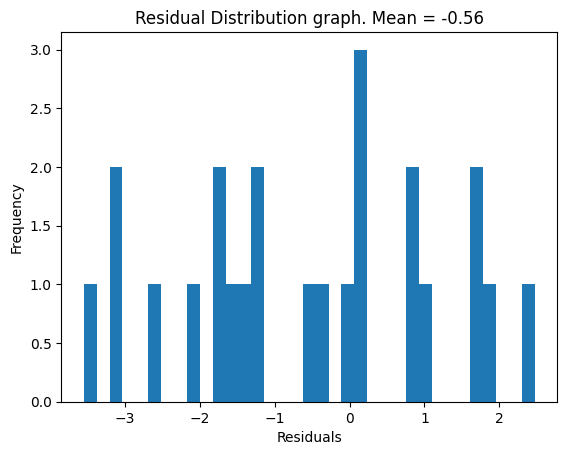

0.5812842814071235

In [8]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Ridge regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.89
R square	0.61
Score		61.38%


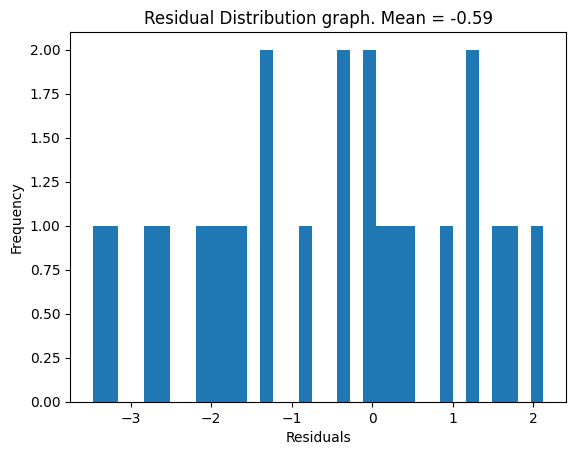

0.6138144594031513

In [9]:
from sklearn import linear_model

model = linear_model.Ridge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Lasso regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.90
R square	0.48
Score		47.89%


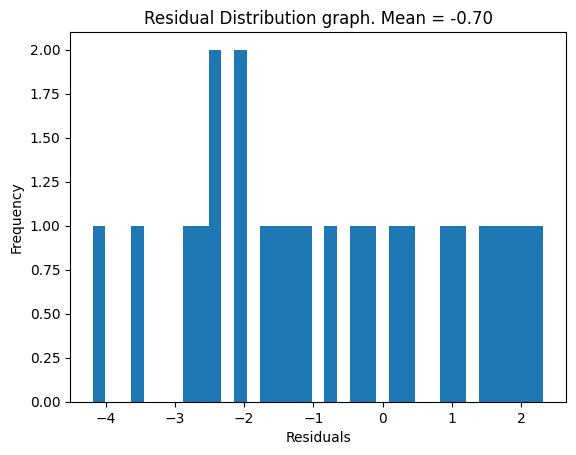

0.4788771701253075

In [10]:
from sklearn import linear_model

model = linear_model.Lasso()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Least Angle regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.13
R square	0.58
Score		58.13%


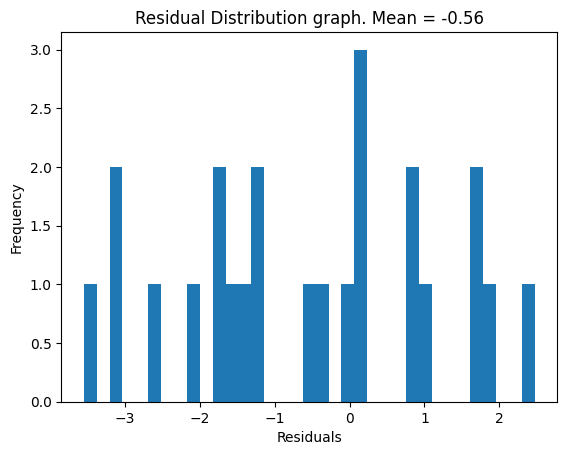

0.581284281407126

In [11]:
from sklearn import linear_model

model = linear_model.Lars()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### ElasticNet regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.28
R square	0.56
Score		56.12%


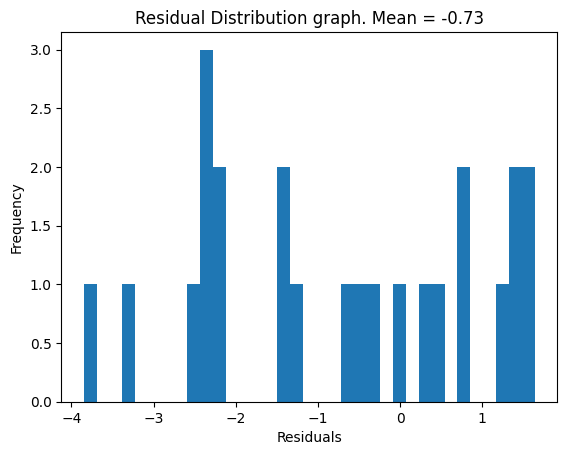

0.5612129954120557

In [12]:
from sklearn import linear_model

model = linear_model.ElasticNet()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Bayesian Ridge regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.00
R square	0.60
Score		59.84%


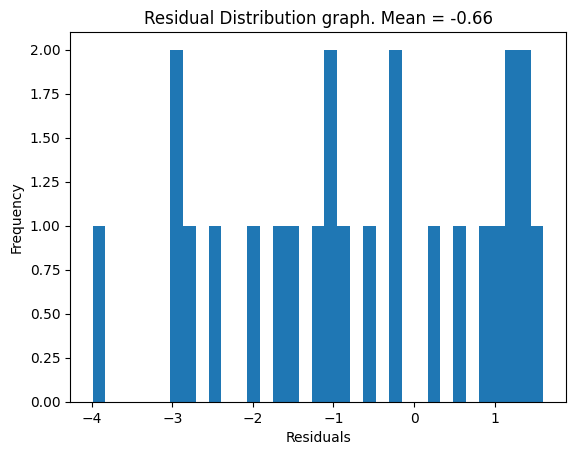

0.5984230116504342

In [13]:
from sklearn import linear_model

model = linear_model.BayesianRidge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Stochastic Gradient Descent regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.96
R square	0.60
Score		60.45%


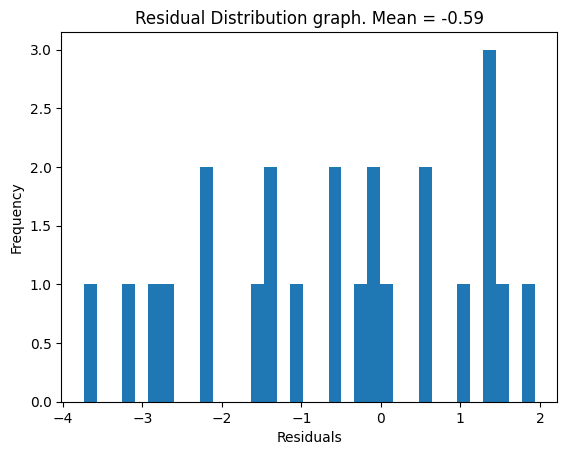

0.6044602263443306

In [14]:
from sklearn import linear_model

model = linear_model.SGDRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Theil-Sen regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.88
R square	0.62
Score		61.52%


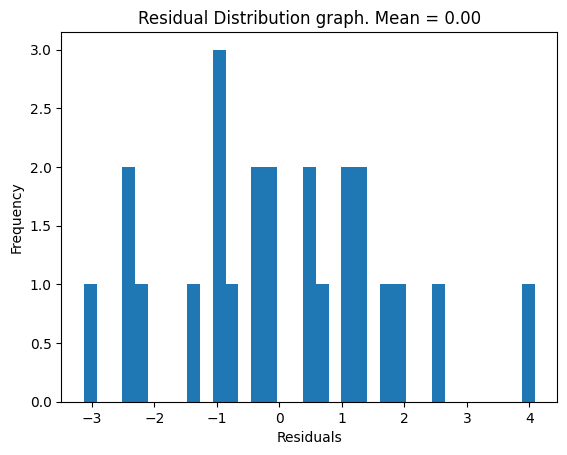

0.6151690072242679

In [15]:
from sklearn import linear_model

model = linear_model.TheilSenRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Huber regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.29
R square	0.69
Score		69.41%


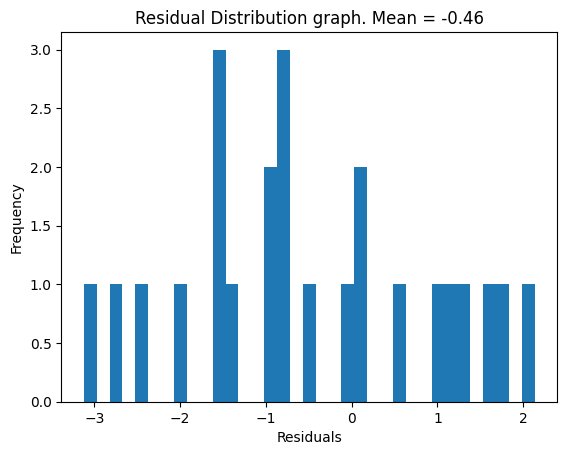

0.6940587407373845

In [16]:
from sklearn import linear_model

model = linear_model.HuberRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Poisson regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.66
R square	0.64
Score		65.02%


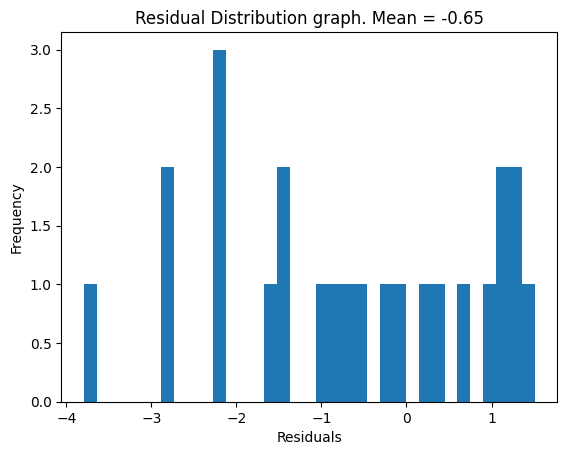

0.6501701772715728

In [17]:
from sklearn import linear_model

model = linear_model.PoissonRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Support Vector Machine

### Epsilon-Support Vector regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.20
R square	0.57
Score		57.25%


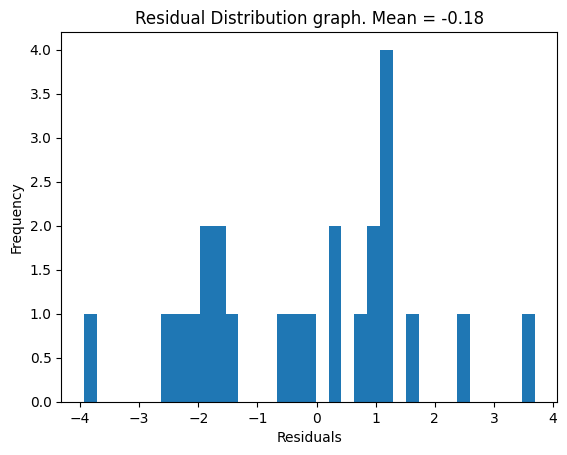

0.5724749379061751

In [18]:
from sklearn import svm

model = svm.SVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Nu Support Vector regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.29
R square	0.56
Score		56.01%


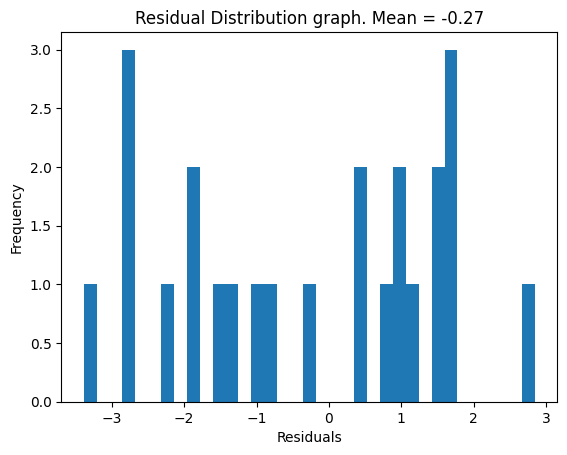

0.5601233149844101

In [19]:
from sklearn import svm

model = svm.NuSVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Nearest Neighbors

In [20]:
k = 3

### K-nearest neighbors based regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.08
R square	0.59
Score		58.83%


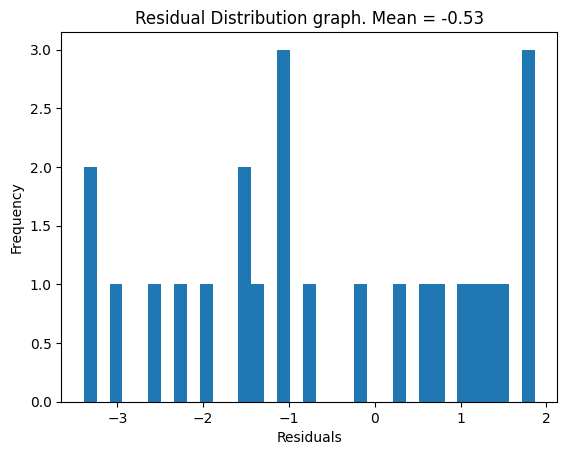

0.5883215832815777

In [21]:
from sklearn import neighbors

model = neighbors.KNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Neighbors within a fixed radius based regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		4.33
R square	0.42
Score		42.15%


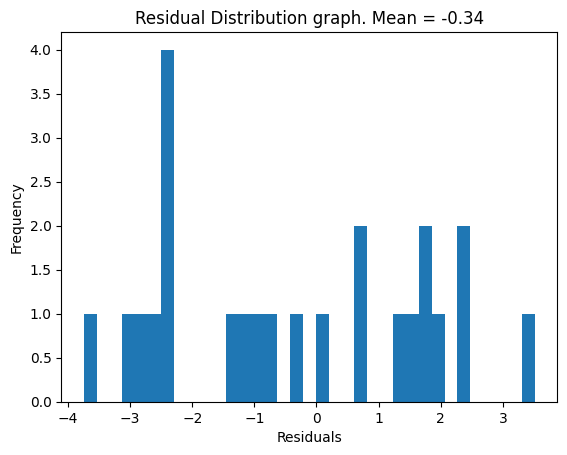

0.42147043867193557

In [22]:
from sklearn import neighbors

model = neighbors.RadiusNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Gaussian Processes

### Gaussian process regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.53
R square	0.66
Score		66.13%


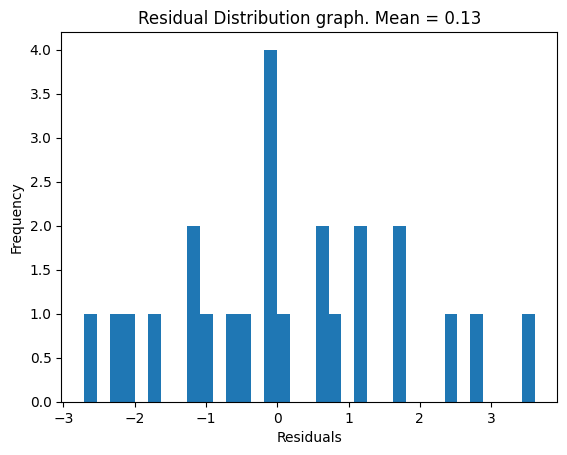

0.6612527770132286

In [23]:
from sklearn import gaussian_process

model = gaussian_process.GaussianProcessRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Decision Trees

### Decision tree regressor


Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.70
R square	0.64
Score		63.97%


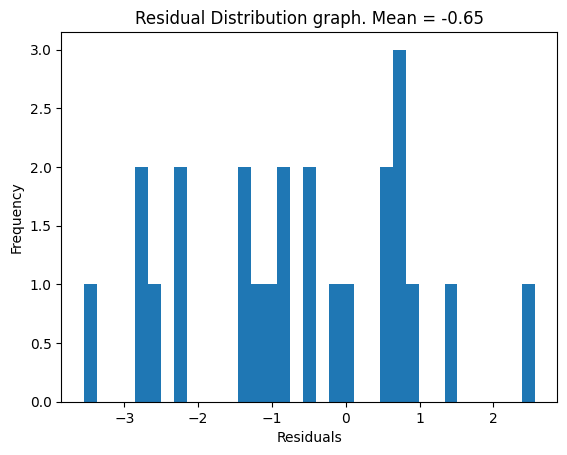

0.6396643782805143

In [24]:
from sklearn import tree

# model = tree.DecisionTreeRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/DecisionTreeRegressor.pkl')
print()

model_summary(y_test, X_test, model)

### Extremely randomized tree regressor

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		1.40
R square	0.81
Score		81.25%


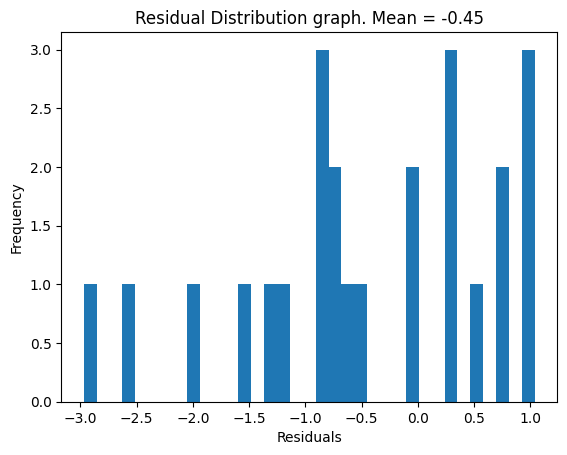

0.8124779350102291

In [25]:
from sklearn import tree

# model = tree.ExtraTreeRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/ExtraTreeRegressor.pkl')

model_summary(y_test, X_test, model)

## Ensemble methods

Regressors are `not` idempotent

### Bagging regressor

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		1.74
R square	0.77
Score		76.80%


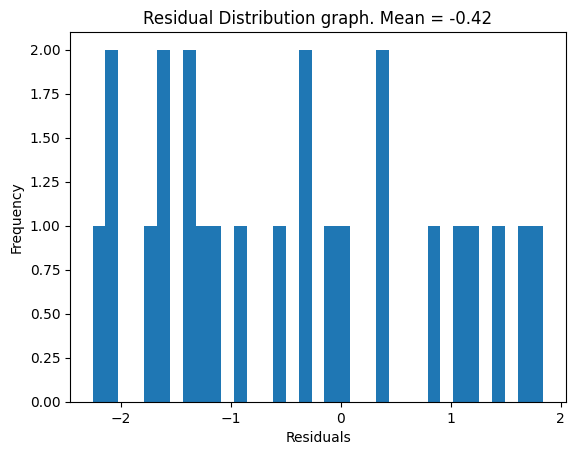

0.7679958678376256

In [26]:
from sklearn import ensemble

# model = ensemble.BaggingRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/BaggingRegressor.pkl')

model_summary(y_test, X_test, model)

### AdaBoost regressor

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.49
R square	0.67
Score		66.78%


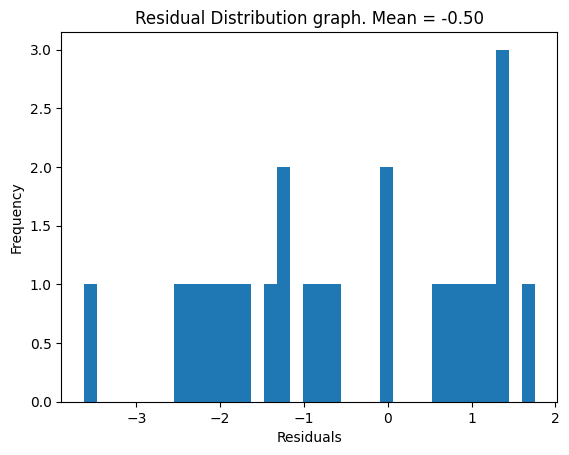

0.6677671847668231

In [27]:
from sklearn import ensemble

# model = ensemble.AdaBoostRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/AdaBoostRegressor.pkl')

model_summary(y_test, X_test, model)

### Extra-trees regressor

This regressor differs from `tree.ExtraTreeRegressor` because it uses averaging to improve the predictive accuracy and control over-fitting using a number of randomized decision trees.

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		1.83
R square	0.76
Score		75.59%


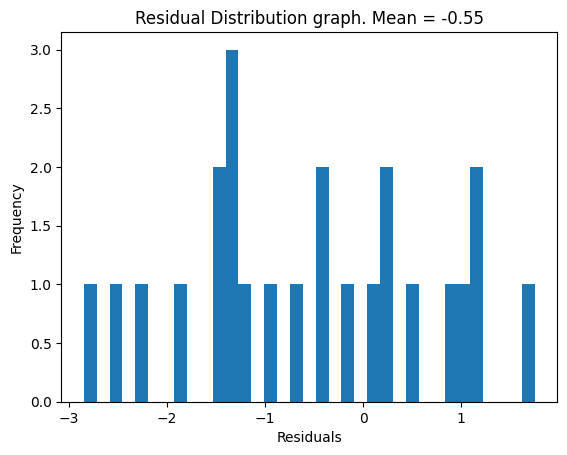

0.755949425280101

In [28]:
from sklearn import ensemble

# model = ensemble.ExtraTreesRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/ExtraTreesRegressor.pkl')

model_summary(y_test, X_test, model)

### Random forest regressor

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.67
R square	0.64
Score		64.27%


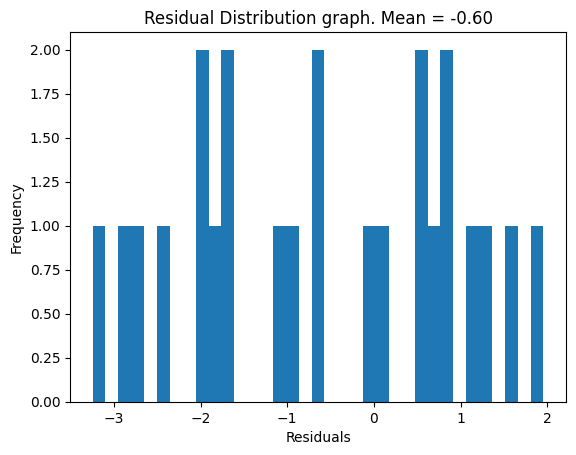

0.6427061780300809

In [29]:
from sklearn import ensemble

# model = ensemble.RandomForestRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/RandomForestRegressor.pkl')

model_summary(y_test, X_test, model)

### Gradient Boosting for regression

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		2.42
R square	0.68
Score		67.66%


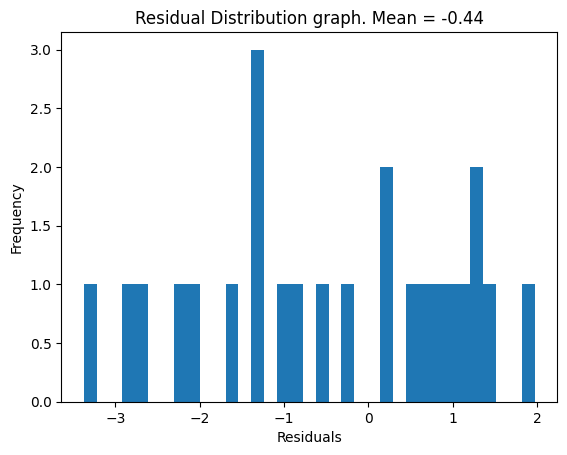

0.6766305850611622

In [30]:
from sklearn import ensemble

# model = ensemble.GradientBoostingRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/GradientBoostingRegressor.pkl')

model_summary(y_test, X_test, model)

### Histogram-based Gradient Boosting Regression Tree

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		3.34
R square	0.55
Score		55.34%


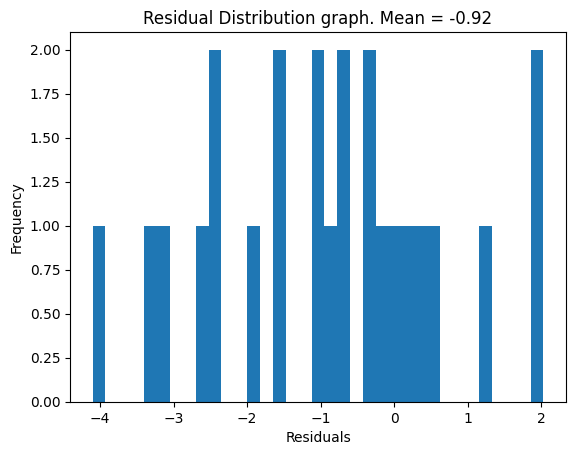

0.5533802495431845

In [31]:
from sklearn import ensemble

# model = ensemble.HistGradientBoostingRegressor()
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/HistGradientBoostingRegressor.pkl')

model_summary(y_test, X_test, model)

## Neural network models

### Multi-layer Perceptron regressor

Mean Squared Error (MSE) lower = better
R square higher = better
Score higher = better

MSE		1.38
R square	0.82
Score		81.62%


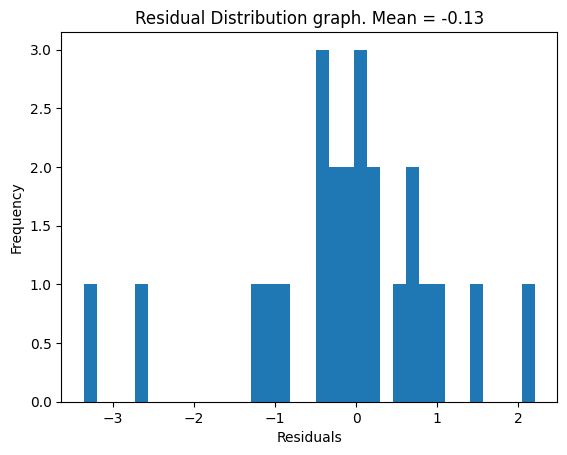

0.8161712381529717

In [32]:
from sklearn import neural_network

# model = neural_network.MLPRegressor(
#     hidden_layer_sizes=[20, 20, 20],
#     max_iter=10000
# )
# model.fit(X_train, y_train)

model = load_instance('./models-persisted/MLPRegressor.pkl')

model_summary(y_test, X_test, model)